In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap 
from scipy.stats import pearsonr
from statistics import mean, stdev
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score
import re


df = pd.read_csv('/Users/linneajensen/Dropbox/ITU/Thesis/Data/eurovision_master.csv')
df0 = pd.read_csv('/Users/linneajensen/Dropbox/ITU/Thesis/Data/eurovision_master_with0.csv')
 

In [123]:
df

,Unnamed: 0,Unnamed: 0.1,year,Artist,from_country,to_country,points,total_points,rank,from_code2,to_code2,Official_languages,Language_sung,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border,televote_points,jury_points,mean_points
0,0,0,1998,Danijela,belgium,croatia,5.0,131,5,BE,HR,croatian,['croatian'],False,True,False,1,True,False,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42,False,0.0,0.0,0.0
1,1,1,1998,Michael Hajiyanni,belgium,cyprus,2.0,37,11,BE,CY,greek turkish,['greek'],False,True,False,1,True,False,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42,False,0.0,0.0,0.0
2,6,6,1998,Guildo Horn feat. Die Orthopädischen Strümpfe,belgium,germany,7.0,86,7,BE,DE,german,['german'],False,True,False,1,True,True,group,22307.0,81678051.0,0.000273,65226.0,10136811.0,0.006435,1995.0,15,True,0.0,0.0,0.0
3,10,10,1998,Dana International,belgium,israel,10.0,172,1,BE,IL,hebrew,['hebrew'],False,True,False,1,True,False,female,4294.0,5545000.0,0.000774,4018.0,10136811.0,0.000396,1995.0,18,False,0.0,0.0,0.0
4,11,11,1998,Chiara,belgium,malta,8.0,165,3,BE,MT,maltese english,['english'],True,False,False,1,True,False,female,23.0,377419.0,0.000061,258.0,10136811.0,0.000025,1995.0,42,False,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8715,21305,21305,2022,Konstrakta,united kingdom,serbia,1.0,169,5,GB,RS,serbian,['serbian'],False,True,False,1,True,False,female,658.0,6899126.0,0.000095,9343.0,67081000.0,0.000139,2020.0,13,False,1.0,1.0,1.0
8716,21306,21306,2022,Chanel,united kingdom,spain,5.0,282,3,GB,ES,spanish,"['spanish', 'english']",True,True,True,2,True,True,female,303193.0,47365655.0,0.006401,150892.0,67081000.0,0.002249,2020.0,51,False,5.0,10.0,7.5
8717,21307,21307,2022,Cornelia Jakobs,united kingdom,sweden,4.0,245,4,GB,SE,swedish,['english'],True,False,False,1,False,True,female,29715.0,10353442.0,0.002870,35824.0,67081000.0,0.000534,2020.0,5,False,4.0,12.0,8.0
8718,21309,21309,2022,Kalush Orchestra,united kingdom,ukraine,12.0,379,1,GB,UA,ukrainian,['ukrainian'],False,True,False,1,True,False,group,0.0,0.0,0.000000,22119.0,67081000.0,0.000330,2020.0,4,False,12.0,0.0,12.0


In [124]:
#Preprocessing
#Q: How to transform and keep Language_sung?
df = df.drop(['from_code2','to_code2','Language_sung',
              'Unnamed: 0','Unnamed: 0.1','total_points','rank'], axis=1)
#Feature extraction
df = df.drop(['televote_points','jury_points',
                'mean_points', 'migration_v2p',
              'migration_p2v','migration_pop_year'], axis=1)
#'televote_points','jury_points','mean_points','migration_pop_year',
#             'migration_v2p','population_p','migration_p2v','population_v'


In [125]:
#OneHotEnconder

# Converting type of columns to category 
df['Artist'] = df['Artist'].astype('category') 
df['from_country'] = df['from_country'].astype('category') 
df['to_country'] = df['to_country'].astype('category') 
df['Official_languages'] = df['Official_languages'].astype('category') 
df['gender'] = df['gender'].astype('category') 

  
#Assigning numerical values and storing it in another columns 
df['Art_new'] = df['Artist'].cat.codes 
df['from_new'] = df['from_country'].cat.codes 
df['to_new'] = df['to_country'].cat.codes 
df['Official_new'] = df['Official_languages'].cat.codes 
df['gen_new'] = df['gender'].cat.codes 

# Create an instance of One-hot-encoder
enc = OneHotEncoder()

# Fit and transform the data
enc_data = enc.fit_transform(df[['Art_new', 'from_new', 'to_new', 'Official_new', 'gen_new']])

# Manually create feature names for the one-hot-encoded columns
feature_names_out = [
    f'{col}_{value}' for col in ['Artist', 'from_country', 'to_country', 'Official_languages', 'gender']
    for value in df[col].cat.categories
]

# Create a DataFrame with the one-hot-encoded data and feature names
enc_df = pd.DataFrame(enc_data.toarray(), columns=feature_names_out)

# Merge with the main DataFrame
new_df = pd.concat([df, enc_df], axis=1)

# Drop the original categorical columns
new_df = new_df.drop(['Artist', 'from_country', 'to_country', 'Official_languages', 'gender','Art_new', 'from_new', 'to_new', 'Official_new', 'gen_new'], axis=1)

# Separate features and target variable
X = new_df.drop('points', axis=1)
y = new_df['points']


In [126]:
new_df

,year,points,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,population_p,prop_emigrants_v2p,population_v,prop_emigrants_p2v,comps_without_win,has_border,Artist_3+2 feat. Robert Wells,Artist_4Fun,Artist_A Friend in London,Artist_AWS,Artist_Afro-Dite,Artist_Aistė,Artist_Aivaras,Artist_Alenka Gotar,Artist_Alex Swings Oscar Sings!,Artist_Alexander Rybak,Artist_Alexander Rybak (2),Artist_Alexej Vorobjov,Artist_Alf Poier,Artist_Aliona Moon,Artist_Alma,Artist_Alma Lusa,Artist_Alsou,Artist_Alvan & Ahez,Artist_Alyona Lanskaya,Artist_Alyosha,Artist_Amaia & Alfred,Artist_Amanda Georgiadi Tenfjord,Artist_Amandine Bourgeois,Artist_Amaury Vassili,Artist_Aminata,Artist_Amir,Artist_Anastasia Prikhodko,Artist_Andrius Pojavis,Artist_András Kállay-Saunders,Artist_André,Artist_Andy Abraham,Artist_Anggun,Artist_Ani Lorak,Artist_Anja,Artist_Anjeza Shahini,Artist_Anna Rossinelli,Artist_Anna Vissi (3),Artist_Anouk,Artist_Antique,Artist_Anxhela Peristeri,Artist_Aram MP3,Artist_Arnis Mednis,Artist_Arsenium feat. Natalia Gordienko & Connect-R,Artist_Artsvik,Artist_Athena,Artist_August & Telma,Artist_AySel & Arash,Artist_Barbara Pravi,Artist_Barei,Artist_Basim,Artist_Benjamin Ingrosso,Artist_Beth,Artist_Bilal Hassani,Artist_Birgit,Artist_Birgitta,Artist_Blanche,Artist_Blind Channel,Artist_Blue,Artist_Blue Café,Artist_Boaz,Artist_Bobbie Singer,Artist_Boggie,Artist_Bojana Stamenov,Artist_Bonaparti.lv,Artist_Bonnie Tyler,Artist_Boris Novković feat. Lado Members,Artist_Brainstorm,Artist_Brian Kennedy,Artist_Brinck,Artist_Buket Bengisu & Grup Safir,Artist_Buranovskiye Babushki,Artist_ByeAlex,Artist_Can Bonomo,Artist_Carl Espen,Artist_Carola (3),Artist_Cascada,Artist_Cesár Sampson,Artist_Cezar,Artist_Chanel,Artist_Chanée & n'evergreen,Artist_Charlie,Artist_Charlotte Nilsson (Perrelli),Artist_Charlotte Perrelli (2),Artist_Charmed,Artist_Chiara,Artist_Chiara (2),Artist_Chiara (3),Artist_Chingiz,Artist_Chris Doran,Artist_Christine Guldbrandsen,Artist_Claudette Pace,Artist_Claudia Beni,Artist_Cláudia Pascoal feat. Isaura,Artist_Compact Disco,Artist_Conchita Wurst,Artist_Constantinos Christoforou (2),Artist_Corinna May,Artist_Cornelia Jakobs,Artist_D'Nash,Artist_Dami Im,Artist_Dana International,Artist_Daniel Diges,Artist_Danijela,Artist_Darja Švajger (2),Artist_David Civera,Artist_Dawn Martin,Artist_Daz Sampson,Artist_Daði og Gagnamagnið,Artist_Deen,Artist_Demy,Artist_Dervish,Artist_Destiny,Artist_Diana Gurtskaya,Artist_Didrik Solli-Tangen,Artist_Dihaj,Artist_Dilara Kazimova,Artist_Dima Bilan,Artist_Dima Bilan (2),Artist_Dina Garipova,Artist_Dino & Béatrice,Artist_Dino Merlin (2),Artist_DoReDoS,Artist_Donatan & Cleo,Artist_Donny Montell,Artist_Donny Montell (2),Artist_Dorians,Artist_Doris Dragović (2),Artist_Douwe Bob,Artist_Duncan Laurence,Artist_ESDM,Artist_Eamonn Toal,Artist_Eddie Butler,Artist_Edea,Artist_Eden,Artist_Eden Alene,Artist_Edsilia Rombley,Artist_Edurne,Artist_Efendi,Artist_Elaiza,Artist_Eldrine,Artist_Electro Velvet,Artist_Eleftheria Eleftheriou,Artist_Elena,Artist_Elena Risteska,Artist_Elena Tsagrinou,Artist_Eleni Foureira,Artist_Elhaida Dani,Artist_Elina Born & Stig Rästa,Artist_Elina Nechayeva,Artist_Elitsa Todorova & Stoyan Yankoulov,Artist_Ell/Nikki,Artist_Elnur & Samir,Artist_Elnur Huseynov (2),Artist_Emma Marrone,Artist_Emmelie de Forest,Artist_Engelbert Humperdinck,Artist_Equinox,Artist_Eric Saade,Artist_Ermal Meta & Fabrizio Moro,Artist_Esther Hart,Artist_Eugent Bushpepa,Artist_Euroband,Artist_Eva Rivas,Artist_Evelin Samuel & Camille,Artist_Evelina Sašenko,Artist_Eythor Ingi,Artist_F.L.Y.,Artist_Fabrizio Faniello,Artist_Fabrizio Faniello (2),Artist_Fame,Artist_Farid Mammadov,Artist_Feminnem,Artist_Filipa Azevedo,Artist_Firelight,Artist_Flor-de-Lis,Artist_Francesca Michielin,Artist_Francesco Gabbani,Artist_Francine Jordi,Artist_Frans,Artist_Freaky Fortune feat. RiskyKidd,Artist_Freddie,Artist_Friends,Artist_Gaitana,Artist_Gary O'Shaughnessy,Artist_Genealogy

In [127]:
#If max_depth is >10, the training learning curve is flat

param_grid = {
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [10, 50, 100, 200, 300],
    'max_features': [2, 4, 8, 'auto', 'sqrt', 'log2'],
    'max_depth': [None, 1, 4, 8, 10, 20, 30],
}

F1-score: 0.15
Classification Report:
              precision    recall  f1-score   support

         1.0       0.17      0.19      0.18       172
         2.0       0.15      0.17      0.16       170
         3.0       0.11      0.10      0.11       173
         4.0       0.11      0.09      0.10       180
         5.0       0.13      0.10      0.11       194
         6.0       0.08      0.08      0.08       151
         7.0       0.08      0.10      0.09       157
         8.0       0.14      0.11      0.12       179
        10.0       0.20      0.20      0.20       188
        12.0       0.37      0.42      0.40       180

    accuracy                           0.16      1744
   macro avg       0.15      0.16      0.15      1744
weighted avg       0.16      0.16      0.16      1744



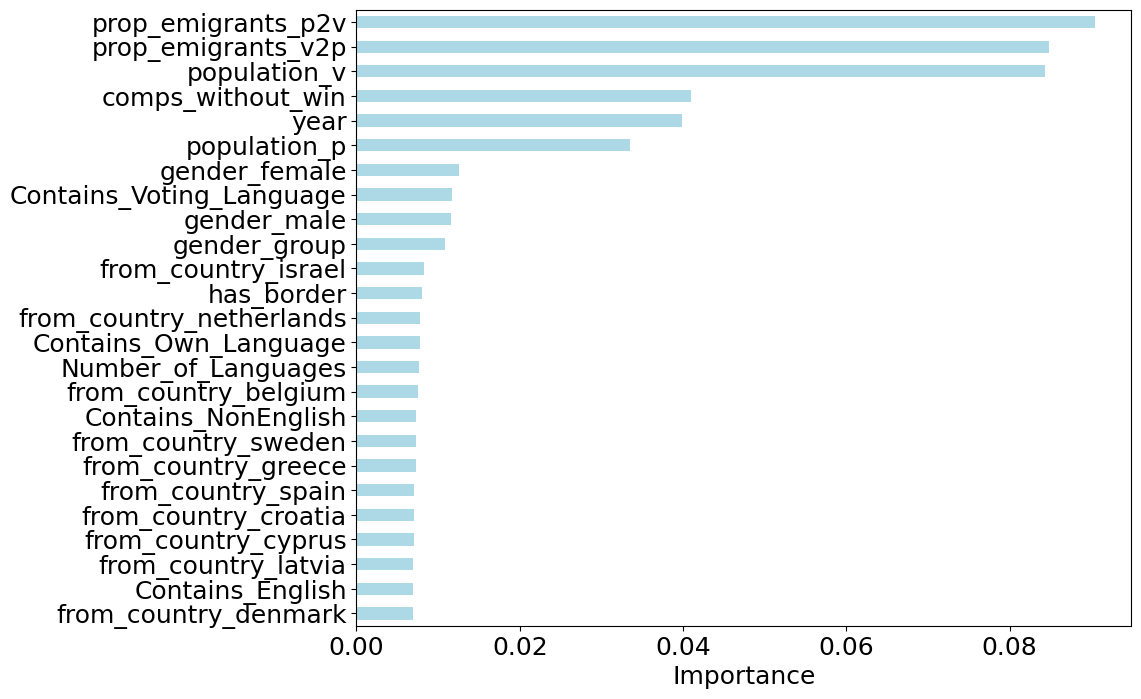

In [134]:
#MODEL 0: Default Settings

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate accuracy
f1 = f1_score(y_test, y_pred, average='macro')

print(f'F1-score: {f1:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

global_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
top_features = global_importances.tail(25)
plt.figure(figsize=(10, 8))
top_features.plot.barh(color='lightblue')
plt.xlabel("Importance")
#plt.savefig('plots/feature_importance_baseline.png', bbox_inches='tight')
plt.show()

              precision    recall  f1-score   support

         1.0       0.15      0.15      0.15       174
         2.0       0.13      0.14      0.13       174
         3.0       0.11      0.11      0.11       175
         4.0       0.09      0.08      0.08       175
         5.0       0.09      0.10      0.10       175
         6.0       0.11      0.11      0.11       174
         7.0       0.11      0.11      0.11       175
         8.0       0.17      0.16      0.16       174
        10.0       0.13      0.11      0.12       174
        12.0       0.37      0.41      0.39       174

    accuracy                           0.15      1744
   macro avg       0.15      0.15      0.15      1744
weighted avg       0.15      0.15      0.15      1744

Outer Fold No 1 - F1_score: 0.15
Outer Fold No 1 - Best model: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 50}
              precision    recall  f1-score   support

         1.0       0.16      0.19   

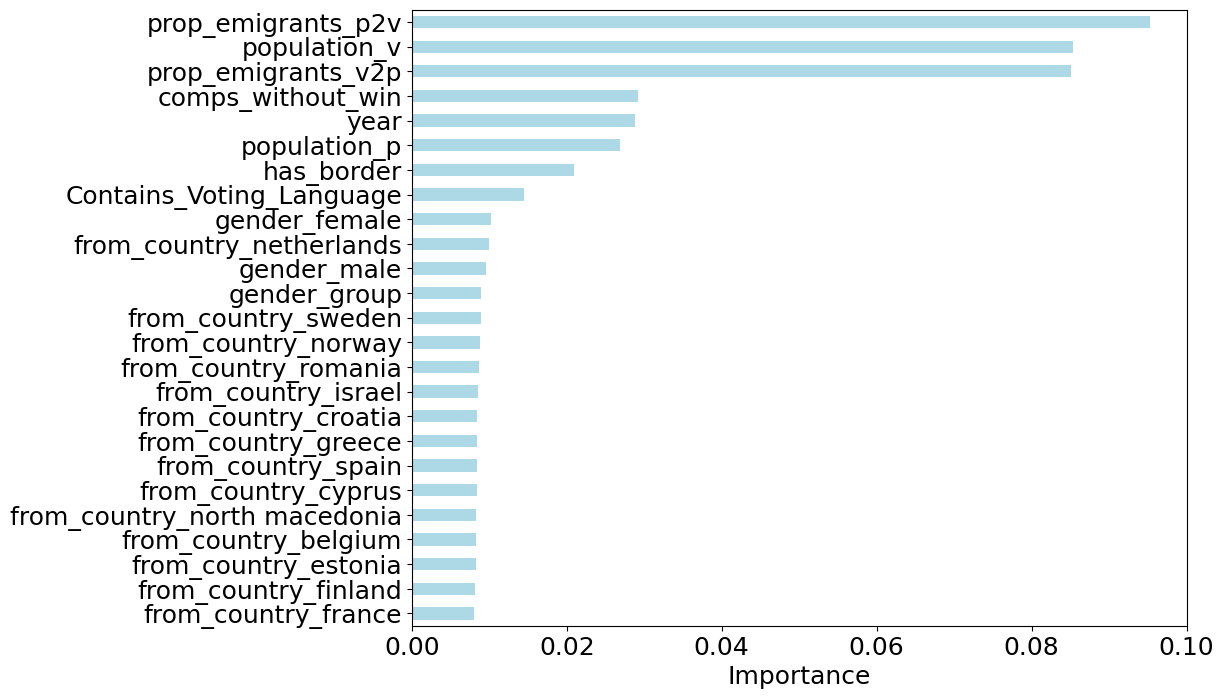

In [80]:
#MODEL 1: Using stratified K-fold, feature extraction and 
#plotting with confusion matrix

# Stratified K-fold for the outer loop
outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store the f1 scores for each outer fold
outer_f1_scores = []

# Confusion matrix variables
overall_cm = None
unique_points = sorted(df['points'].unique())

# Outer Cross-Validation Loop
for n, (outer_train_index, outer_test_index) in enumerate(outer_kfold.split(X, y)):
    X_outer_train, X_outer_test = X.iloc[outer_train_index], X.iloc[outer_test_index]
    y_outer_train, y_outer_test = y.iloc[outer_train_index], y.iloc[outer_test_index]

    # Inner Cross-Validation Loop for Hyperparameter Tuning
    inner_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Hyperparameter tuning using GridSearchCV
    model = RandomForestClassifier(random_state=42)
    search = GridSearchCV(model, param_grid, scoring='f1_macro', cv=inner_kfold, refit=True)
    result = search.fit(X_outer_train, y_outer_train)
    best_model = result.best_estimator_

    # Evaluate the best model on the outer test set
    y_outer_pred = best_model.predict(X_outer_test)
    print(classification_report(y_outer_test, y_outer_pred))

    # Calculate the confusion matrix for this fold
    cm_fold = confusion_matrix(y_outer_test, y_outer_pred)

    # Add the confusion matrix for this fold to the overall confusion matrix
    if overall_cm is None:
        overall_cm = cm_fold
    else:
        overall_cm += cm_fold

    # Calculate f1 score for this fold
    outer_f1 = f1_score(y_outer_test, y_outer_pred, average='macro')
    outer_f1_scores.append(outer_f1)

    print(f'Outer Fold No {n + 1} - F1_score: {outer_f1:.2f}')
    print(f'Outer Fold No {n + 1} - Best model: {result.best_params_}')

# Print the mean f1 score across all outer folds
print("Mean f1 score: ", mean(outer_f1_scores))

global_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
top_features = global_importances.tail(25)
plt.figure(figsize=(10, 8))
top_features.plot.barh(color='lightblue')
plt.xlabel("Importance")
plt.savefig('plots/feature_importance_stratified.png', bbox_inches='tight')
plt.show()

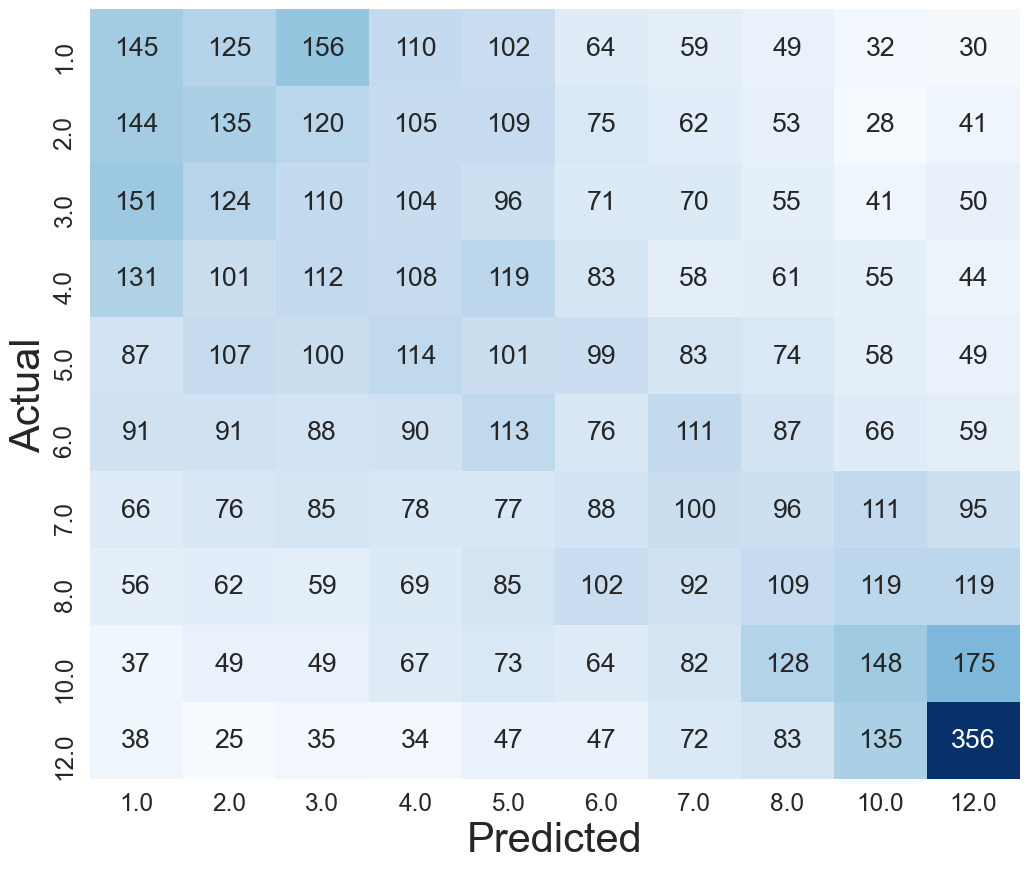

In [81]:
# Visualize the overall confusion matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.6)
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=unique_points, yticklabels=unique_points)
plt.xlabel('Predicted',fontsize=30)
plt.ylabel('Actual',fontsize=30)
plt.savefig('plots/models/ConfusionMatrix_ex0.png', bbox_inches='tight')
plt.show()

Outer Fold No 1 - Best model parameters for delta-t 2: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 50} - F1-score: 0.10713874332858235
Outer Fold No 2 - Best model parameters for delta-t 2: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 2, 'n_estimators': 50} - F1-score: 0.09553893395837129
Outer Fold No 3 - Best model parameters for delta-t 2: {'max_depth': None, 'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 200} - F1-score: 0.0944702164300408
Outer Fold No 4 - Best model parameters for delta-t 2: {'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 2, 'n_estimators': 50} - F1-score: 0.0975166917292358
Outer Fold No 5 - Best model parameters for delta-t 2: {'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 100} - F1-score: 0.09096418878236863
Outer Fold No 6 - Best model parameters for delta-t 2: {'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 300} - F1-score: 0.15240828

Outer Fold No 9 - Best model parameters for delta-t 4: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300} - F1-score: 0.1133606697993571
Outer Fold No 10 - Best model parameters for delta-t 4: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50} - F1-score: 0.1125556183319921
Outer Fold No 11 - Best model parameters for delta-t 4: {'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 50} - F1-score: 0.13735400453120983
Outer Fold No 12 - Best model parameters for delta-t 4: {'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 200} - F1-score: 0.156628221242721
Outer Fold No 13 - Best model parameters for delta-t 4: {'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 300} - F1-score: 0.11467993578019742
Outer Fold No 14 - Best model parameters for delta-t 4: {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 300} - F1-score: 0

Outer Fold No 3 - Best model parameters for delta-t 7: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 50} - F1-score: 0.15557209925682572
Outer Fold No 4 - Best model parameters for delta-t 7: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 10} - F1-score: 0.12573084877188098
Outer Fold No 5 - Best model parameters for delta-t 7: {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 300} - F1-score: 0.12622054556728463
Outer Fold No 6 - Best model parameters for delta-t 7: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 10} - F1-score: 0.1184391299642038
Outer Fold No 7 - Best model parameters for delta-t 7: {'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 100} - F1-score: 0.10144519386333314
Outer Fold No 8 - Best model parameters for delta-t 7: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300} - F1

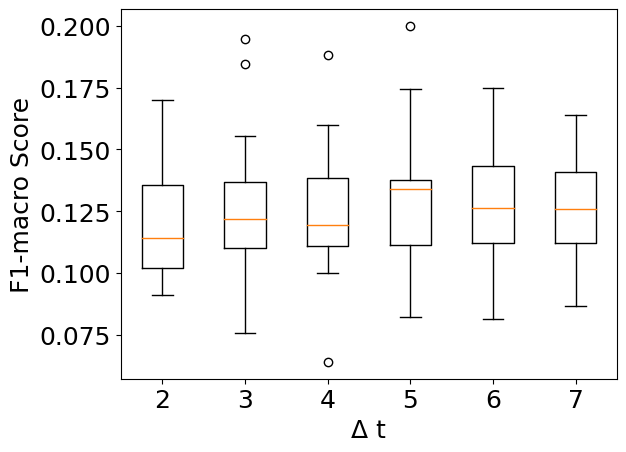

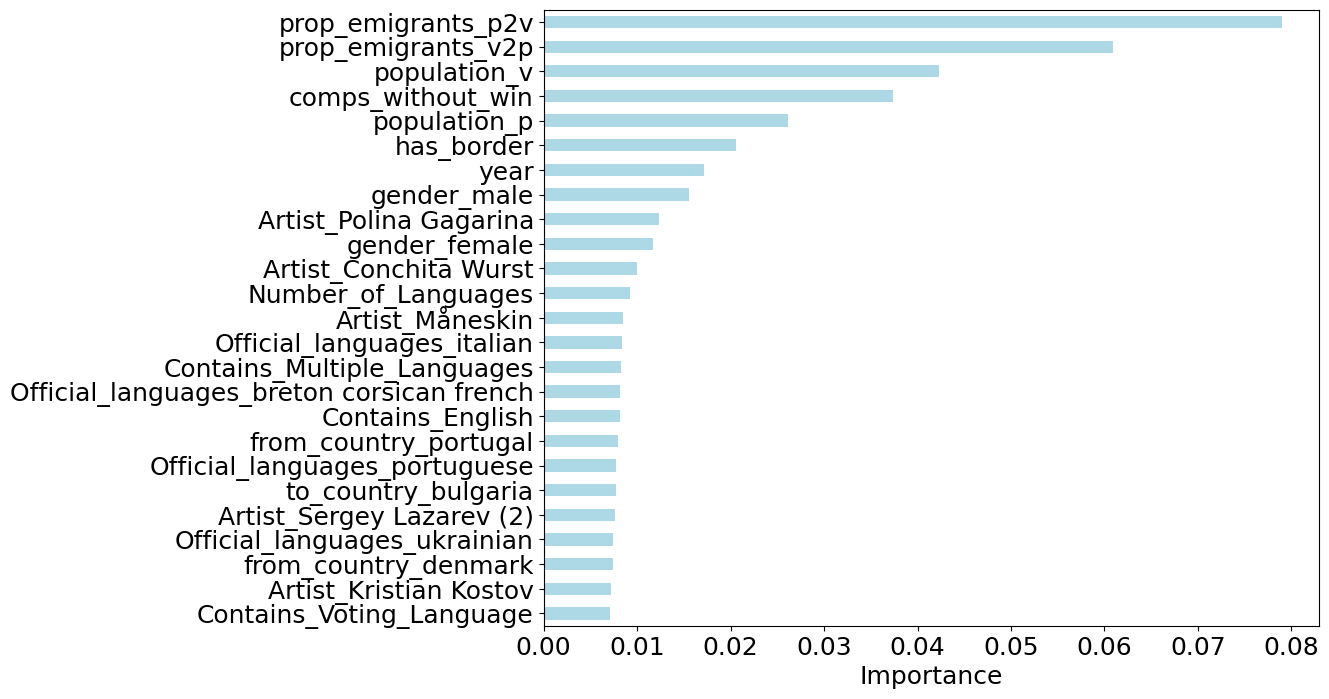

In [137]:
#MODEL 2: Delta-t

# List to store F1-macro scores for different delta-t values
f1_macro_scores = []

# Number of years in your dataset
years = df['year'].unique()
num_years = len(years)

# Define a range of delta-t values
delta_t_values = range(2, 8)

# Iterate through different delta-t values
for delta_t in delta_t_values:
    f1_scores = []  # Store F1-macro scores for the current delta-t
    #for start_year in range(min(years), max(years) - delta_t + 2):
    for i, start_year in enumerate(years[:-delta_t + 1]):
        # Define the training years and test year
        train_years = years[i:i + delta_t]
        test_year = start_year + delta_t

        # Check if there is data for the training years
        if X[df['year'].isin(train_years)].shape[0] == 0:
            continue  # Skip this iteration if there's no data for the training years
        # Check if there is data for the test year
        if X[df['year'] == test_year].shape[0] == 0:
            continue  # Skip this iteration if there's no data for the test year
    
        # Replace skipped years with the next available year
        train_years = [year if year in years else min(years, key=lambda x: abs(x - year)) for year in train_years]
        test_year = min(years, key=lambda x: abs(x - test_year))

        # Adjust test year if a skipped year is encountered in the training years
        if train_years[-1] != start_year + delta_t - 1:
            test_year += 1

        # Skip iteration if the adjusted test year is 2020
        if test_year == 2020 or test_year == 2023:
            continue
            
        # Split the data into training and test sets
        # X_train and y_train are the training data and labels
        X_train = X[df['year'].isin(train_years)]  # Select rows where 'Year' matches train_years
        y_train = y[df['year'].isin(train_years)]  # Corresponding labels

        # X_test and y_test are the test data and labels
        X_test = X[df['year'] == test_year]  # Select rows where 'Year' matches test_year
        y_test = y[df['year'] == test_year]  # Corresponding labels

        # Check if X_test is empty
        if X_test.shape[0] == 0:
            continue  # Skip this iteration if X_test is empty

        # Train a Random Forest Classifier with nested cross-validation
        inner_cv = 3  # Adjust the inner cross-validation folds as needed
        outer_cv = 5  # Adjust the outer cross-validation folds as needed

        # Define the inner cross-validation grid search
        clf = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=inner_cv,
                           scoring=make_scorer(f1_score, average='macro'))

        # Perform grid search on the inner training set
        clf.fit(X_train, y_train)

        # Use the best parameters to train the model on the entire training set
        best_params = clf.best_params_
        
        # Train a Random Forest Classifier
        model = RandomForestClassifier(**best_params, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate the F1-macro score
        f1 = f1_score(y_test, y_pred, average='macro')
        f1_scores.append(f1)
        print(f'Outer Fold No {i + 1} - Best model parameters for delta-t {delta_t}: {best_params} - F1-score: {f1}')


    # Store the F1-macro scores for the current delta-t
    f1_macro_scores.append(f1_scores)

# Calculate mean F1-macro scores for each delta_t
mean_f1_macro_scores = [np.mean(scores) for scores in f1_macro_scores]

# Print or use mean_f1_macro_scores as needed
print(mean_f1_macro_scores) 
print("Mean of all: ", mean(mean_f1_macro_scores))
    
# Create a boxplot to visualize the F1-macro scores for different delta-t values
plt.boxplot(f1_macro_scores)
plt.xticks(range(1, len(delta_t_values) + 1), delta_t_values)
plt.xlabel('Δ t')
plt.ylabel('F1-macro Score')
#plt.savefig('plots/models/Delta_t_boxplot.png', bbox_inches='tight')
plt.show()

global_importances = pd.Series(model.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
top_features = global_importances.tail(25)
plt.figure(figsize=(10, 8))
top_features.plot.barh(color='lightblue')
plt.xlabel("Importance")
plt.savefig('plots/feature_importance_Delta.png', bbox_inches='tight')
plt.show()

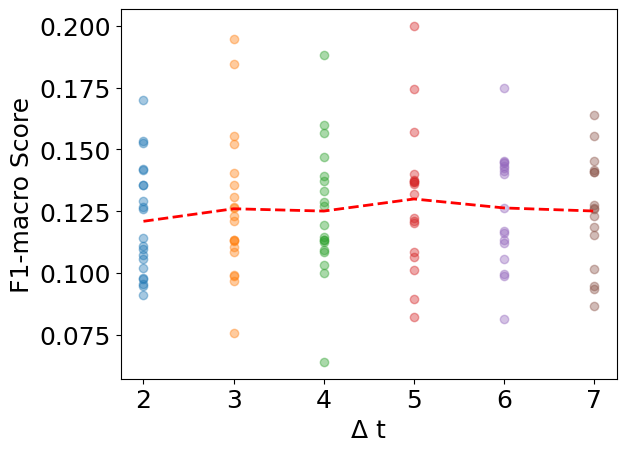

In [138]:
# Plot individual data points as dots
for i, delta_t in enumerate(delta_t_values):
    plt.scatter([i + 1] * len(f1_macro_scores[i]), f1_macro_scores[i], label=f'Delta-t={delta_t}', alpha=0.4)

average_scores = [np.mean(scores) for scores in f1_macro_scores]
plt.plot(range(1, len(delta_t_values) + 1), average_scores, color='red', linestyle='--', label='Average', linewidth=2)

plt.xticks(range(1, len(delta_t_values) + 1), delta_t_values)
plt.xlabel('Δ t')
plt.ylabel('F1-macro Score')
#plt.savefig('plots/models/Delta_t_scatter.png', bbox_inches='tight')
plt.show()

In [139]:
#MODEL 3: Including 0 in dataset
df0 = pd.read_csv('/Users/linneajensen/Dropbox/ITU/Thesis/Data/eurovision_master_with0.csv')


In [140]:
df0

,Unnamed: 0,Unnamed: 0.1,year,Artist,from_country,to_country,points,total_points,rank,from_code2,to_code2,Official_languages,Language_sung,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_without_win,has_border,televote_points,jury_points,mean_points
0,0,0,1998,Danijela,belgium,croatia,5.0,131,5,BE,HR,croatian,['croatian'],False,True,False,1,True,False,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42,False,0.0,0.0,0.0
1,1,1,1998,Michael Hajiyanni,belgium,cyprus,2.0,37,11,BE,CY,greek turkish,['greek'],False,True,False,1,True,False,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42,False,0.0,0.0,0.0
2,2,2,1998,Koit Toome,belgium,estonia,0.0,36,12,BE,EE,võro estonian,['estonian'],False,True,False,1,True,False,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42,False,0.0,0.0,0.0
3,3,3,1998,Vlado Janevski,belgium,north macedonia,0.0,16,19,BE,MK,macedonian albanian,['macedonian'],False,True,False,1,True,False,male,0.0,0.0,0.000000,120.0,10136811.0,0.000012,1995.0,42,False,0.0,0.0,0.0
4,4,4,1998,Edea,belgium,finland,0.0,22,15,BE,FI,finnish swedish,['finnish'],False,True,False,1,True,False,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42,False,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21306,21306,21306,2022,Chanel,united kingdom,spain,5.0,282,3,GB,ES,spanish,"['spanish', 'english']",True,True,True,2,True,True,female,303193.0,47365655.0,0.006401,150892.0,67081000.0,0.002249,2020.0,51,False,5.0,10.0,7.5
21307,21307,21307,2022,Cornelia Jakobs,united kingdom,sweden,4.0,245,4,GB,SE,swedish,['english'],True,False,False,1,False,True,female,29715.0,10353442.0,0.002870,35824.0,67081000.0,0.000534,2020.0,5,False,4.0,12.0,8.0
21308,21308,21308,2022,Marius Bear,united kingdom,switzerland,0.0,28,18,GB,CH,french bern fribourg geneva jura neuchâtel val...,['english'],True,False,False,1,False,True,male,45951.0,8638167.0,0.005320,23649.0,67081000.0,0.000353,2020.0,32,False,0.0,2.0,2.0
21309,21309,21309,2022,Kalush Orchestra,united kingdom,ukraine,12.0,379,1,GB,UA,ukrainian,['ukrainian'],False,True,False,1,True,False,group,0.0,0.0,0.000000,22119.0,67081000.0,0.000330,2020.0,4,False,12.0,0.0,12.0


In [141]:
#Q: How to transform and keep Language_sung?
df0 = df0.drop(['from_code2','to_code2','Language_sung',
              'Unnamed: 0','Unnamed: 0.1'], axis=1)
#Feature extraction
df0 = df0.drop(['televote_points','jury_points',
                'mean_points', 'migration_v2p',
              'migration_p2v','migration_pop_year', 'total_points','rank'], axis=1)
#'televote_points','jury_points','mean_points','migration_pop_year',
#             'migration_v2p','population_p','migration_p2v','population_v'
df0

,year,Artist,from_country,to_country,points,Official_languages,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,gender,population_p,prop_emigrants_v2p,population_v,prop_emigrants_p2v,comps_without_win,has_border
0,1998,Danijela,belgium,croatia,5.0,croatian,False,True,False,1,True,False,female,4620030.0,0.000044,10136811.0,0.000007,42,False
1,1998,Michael Hajiyanni,belgium,cyprus,2.0,greek turkish,False,True,False,1,True,False,male,862418.0,0.000107,10136811.0,0.000008,42,False
2,1998,Koit Toome,belgium,estonia,0.0,võro estonian,False,True,False,1,True,False,male,1436634.0,0.000000,10136811.0,0.000006,42,False
3,1998,Vlado Janevski,belgium,north macedonia,0.0,macedonian albanian,False,True,False,1,True,False,male,0.0,0.000000,10136811.0,0.000012,42,False
4,1998,Edea,belgium,finland,0.0,finnish swedish,False,True,False,1,True,False,group,5107790.0,0.000028,10136811.0,0.000152,42,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21306,2022,Chanel,united kingdom,spain,5.0,spanish,True,True,True,2,True,True,female,47365655.0,0.006401,67081000.0,0.002249,51,False
21307,2022,Cornelia Jakobs,united kingdom,sweden,4.0,swedish,True,False,False,1,False,True,female,10353442.0,0.002870,67081000.0,0.000534,5,False
21308,2022,Marius Bear,united kingdom,switzerland,0.0,french bern fribourg geneva jura neuchâtel val...,True,False,False,1,False,True,male,8638167.0,0.005320,67081000.0,0.000353,32,False
21309,2022,Kalush Orchestra,united kingdom,ukraine,12.0,ukrainian,False,True,False,1,True,False,group,0.0,0.000000,67081000.0,0.000330,4,False


In [142]:
#Create features (X) and target value (y), the points
X_0 = df0.drop('points', axis=1)
y_0 = df0['points']

In [143]:
df0

,year,Artist,from_country,to_country,points,Official_languages,Contains_English,Contains_NonEnglish,Contains_Multiple_Languages,Number_of_Languages,Contains_Own_Language,Contains_Voting_Language,gender,population_p,prop_emigrants_v2p,population_v,prop_emigrants_p2v,comps_without_win,has_border
0,1998,Danijela,belgium,croatia,5.0,croatian,False,True,False,1,True,False,female,4620030.0,0.000044,10136811.0,0.000007,42,False
1,1998,Michael Hajiyanni,belgium,cyprus,2.0,greek turkish,False,True,False,1,True,False,male,862418.0,0.000107,10136811.0,0.000008,42,False
2,1998,Koit Toome,belgium,estonia,0.0,võro estonian,False,True,False,1,True,False,male,1436634.0,0.000000,10136811.0,0.000006,42,False
3,1998,Vlado Janevski,belgium,north macedonia,0.0,macedonian albanian,False,True,False,1,True,False,male,0.0,0.000000,10136811.0,0.000012,42,False
4,1998,Edea,belgium,finland,0.0,finnish swedish,False,True,False,1,True,False,group,5107790.0,0.000028,10136811.0,0.000152,42,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21306,2022,Chanel,united kingdom,spain,5.0,spanish,True,True,True,2,True,True,female,47365655.0,0.006401,67081000.0,0.002249,51,False
21307,2022,Cornelia Jakobs,united kingdom,sweden,4.0,swedish,True,False,False,1,False,True,female,10353442.0,0.002870,67081000.0,0.000534,5,False
21308,2022,Marius Bear,united kingdom,switzerland,0.0,french bern fribourg geneva jura neuchâtel val...,True,False,False,1,False,True,male,8638167.0,0.005320,67081000.0,0.000353,32,False
21309,2022,Kalush Orchestra,united kingdom,ukraine,12.0,ukrainian,False,True,False,1,True,False,group,0.0,0.000000,67081000.0,0.000330,4,False


In [144]:
#OneHotEnconder

# Converting type of columns to category 
df0['Artist'] = df0['Artist'].astype('category') 
df0['from_country'] = df0['from_country'].astype('category') 
df0['to_country'] = df0['to_country'].astype('category') 
df0['Official_languages'] = df0['Official_languages'].astype('category') 
df0['gender'] = df0['gender'].astype('category') 

  
#Assigning numerical values and storing it in another columns 
df0['Art_new'] = df0['Artist'].cat.codes 
df0['from_new'] = df0['from_country'].cat.codes 
df0['to_new'] = df0['to_country'].cat.codes 
df0['Official_new'] = df0['Official_languages'].cat.codes 
df0['gen_new'] = df0['gender'].cat.codes 


# Create an instance of One-hot-encoder
enc = OneHotEncoder()

# Fit and transform the data
enc_data = enc.fit_transform(df0[['Art_new', 'from_new', 'to_new', 'Official_new', 'gen_new']])

# Manually create feature names for the one-hot-encoded columns
feature_names_out = [
    f'{col}_{value}' for col in ['Artist', 'from_country', 'to_country', 'Official_languages', 'gender']
    for value in df0[col].cat.categories
]

# Create a DataFrame with the one-hot-encoded data and feature names
enc_df = pd.DataFrame(enc_data.toarray(), columns=feature_names_out)

# Merge with the main DataFrame
new_df0 = pd.concat([df0, enc_df], axis=1)

# Drop the original categorical columns
new_df0 = new_df0.drop(['Artist', 'from_country', 'to_country', 'Official_languages', 'gender','Art_new', 'from_new', 'to_new', 'Official_new', 'gen_new'], axis=1)

# Separate features and target variable
X_0 = new_df0.drop('points', axis=1)
y_0 = new_df0['points']


In [145]:
#MODEL 1 WITH 0: Using stratified K-fold, feature extraction and 
#plotting with confusion matrix

# Stratified K-fold for the outer loop
outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store the f1 scores for each outer fold
outer_f1_scores = []

# Confusion matrix variables
overall_cm = None
unique_points = sorted(df['points'].unique())

# Outer Cross-Validation Loop
for n, (outer_train_index, outer_test_index) in enumerate(outer_kfold.split(X_0, y_0)):
    X_outer_train, X_outer_test = X_0.iloc[outer_train_index], X_0.iloc[outer_test_index]
    y_outer_train, y_outer_test = y_0.iloc[outer_train_index], y_0.iloc[outer_test_index]

    # Inner Cross-Validation Loop for Hyperparameter Tuning
    inner_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Hyperparameter tuning using GridSearchCV
    model = RandomForestClassifier(random_state=42)
    search = GridSearchCV(model, param_grid, scoring='f1_macro', cv=inner_kfold, refit=True)
    result = search.fit(X_outer_train, y_outer_train)
    best_model = result.best_estimator_

    # Evaluate the best model on the outer test set
    y_outer_pred = best_model.predict(X_outer_test)
    print(classification_report(y_outer_test, y_outer_pred))

    # Calculate the confusion matrix for this fold
    cm_fold = confusion_matrix(y_outer_test, y_outer_pred)

    # Add the confusion matrix for this fold to the overall confusion matrix
    if overall_cm is None:
        overall_cm = cm_fold
    else:
        overall_cm += cm_fold

    # Calculate f1 score for this fold
    outer_f1 = f1_score(y_outer_test, y_outer_pred, average='macro')
    outer_f1_scores.append(outer_f1)

    print(f'Outer Fold No {n + 1} - F1_score: {outer_f1:.2f}')
    print(f'Outer Fold No {n + 1} - Best model: {best_model}')


# Print the mean f1 score across all outer folds
print("Mean f1 score: ", mean(outer_f1_scores))


              precision    recall  f1-score   support

         0.0       0.70      0.97      0.82      2518
         1.0       0.07      0.01      0.02       174
         2.0       0.03      0.01      0.01       174
         3.0       0.13      0.04      0.06       175
         4.0       0.10      0.03      0.05       174
         5.0       0.08      0.03      0.05       175
         6.0       0.07      0.03      0.04       175
         7.0       0.11      0.06      0.08       175
         8.0       0.24      0.13      0.17       175
        10.0       0.26      0.17      0.21       174
        12.0       0.44      0.45      0.45       174

    accuracy                           0.61      4263
   macro avg       0.20      0.18      0.18      4263
weighted avg       0.48      0.61      0.53      4263

Outer Fold No 1 - F1_score: 0.18
Outer Fold No 1 - Best model: RandomForestClassifier(n_estimators=50, random_state=42)
              precision    recall  f1-score   support

         0.0

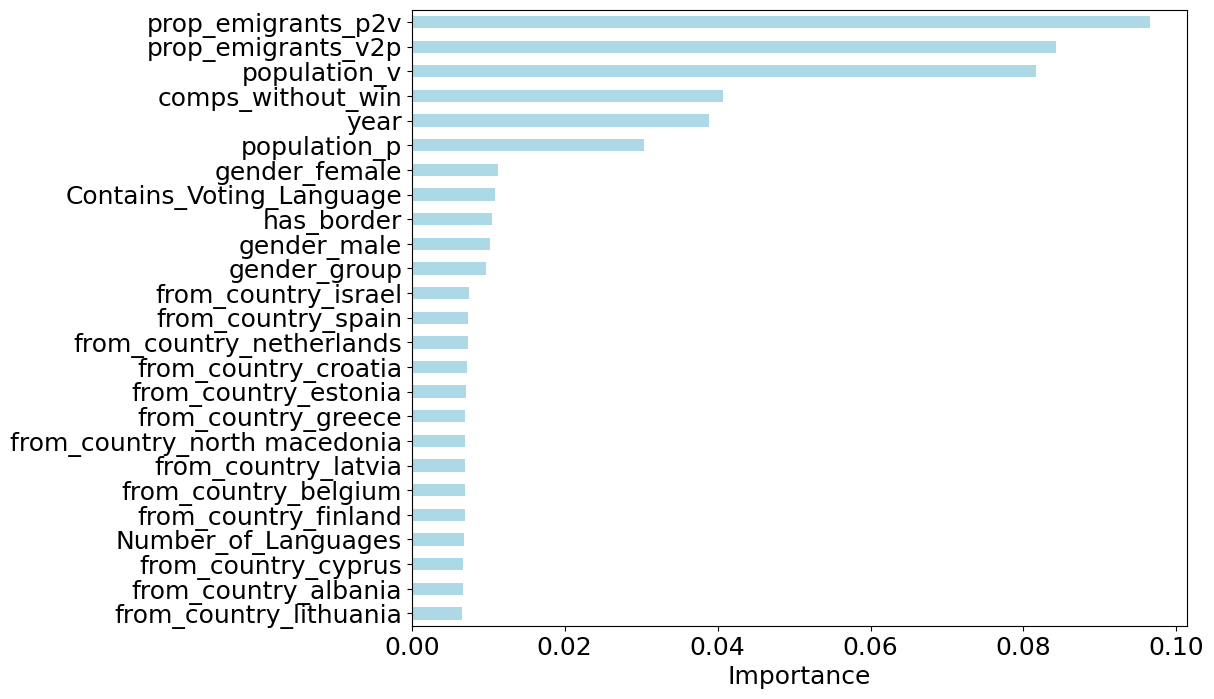

In [150]:
global_importances = pd.Series(best_model.feature_importances_, index=X_outer_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
top_features = global_importances.tail(25)
plt.figure(figsize=(10, 8))
top_features.plot.barh(color='lightblue')
plt.xlabel("Importance")
plt.savefig('plots/feature_importance_Stratified0_with.png', bbox_inches='tight')
plt.show()

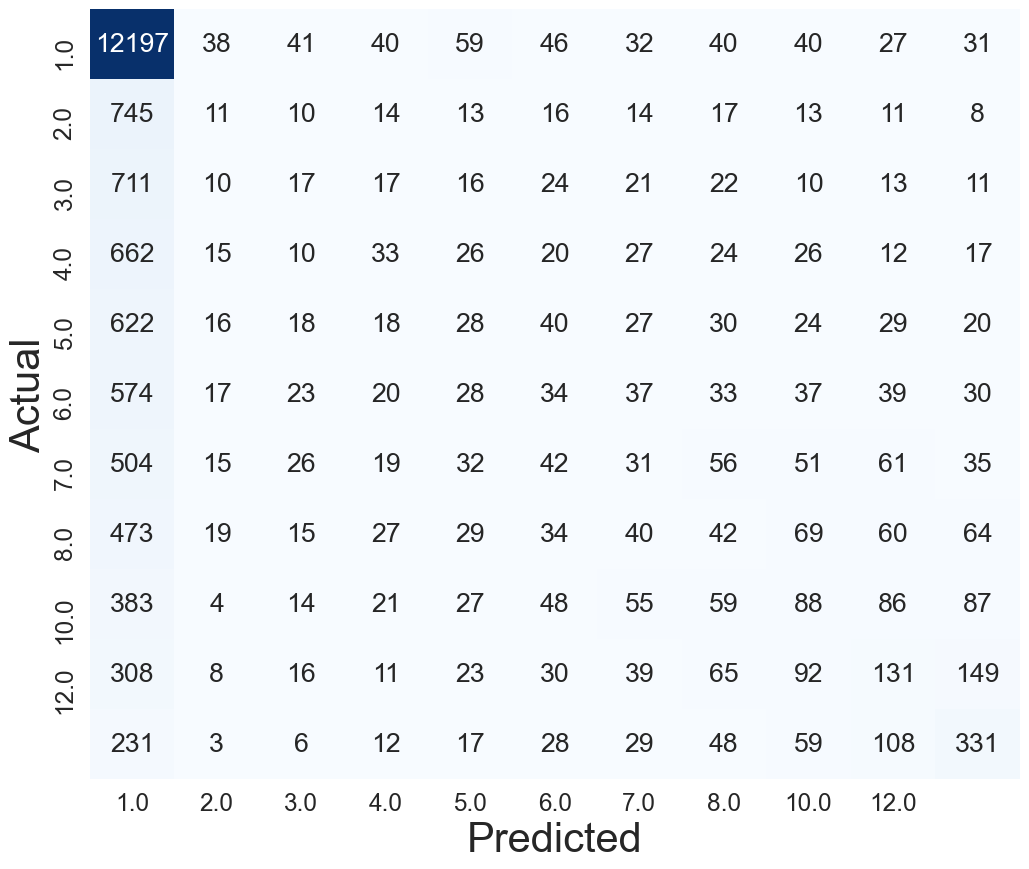

In [151]:
# Visualize the overall confusion matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.6)
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=unique_points, yticklabels=unique_points)
plt.xlabel('Predicted',fontsize=30)
plt.ylabel('Actual',fontsize=30)
#plt.savefig('plots/models/ConfusionMatrix_incl0.png', bbox_inches='tight')
plt.show()

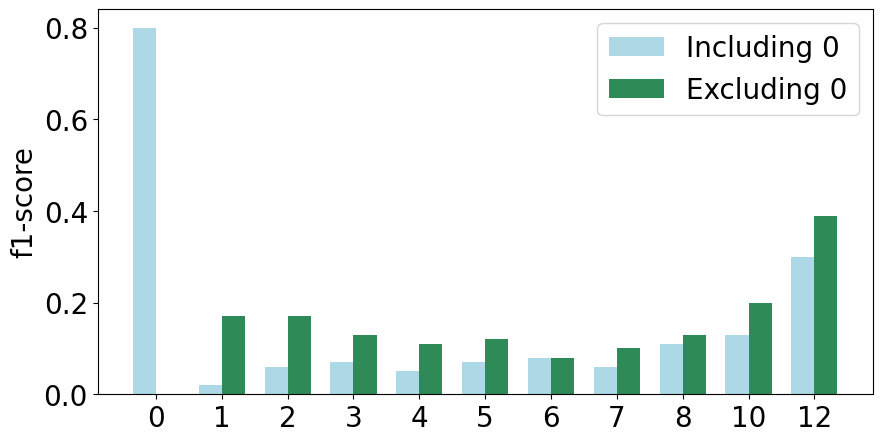

In [160]:
#Plotting 0-model

import matplotlib.pyplot as plt
import numpy as np

data_incl0 = {
    '0': 0.80,
    '1': 0.02,
    '2': 0.06,
    '3': 0.07,
    '4': 0.05,
    '5': 0.07,
    '6': 0.08,
    '7': 0.06,
    '8': 0.11,
    '10': 0.13,
    '12': 0.30
}
data_ex0 = {
    '0': 0.00,
    '1': 0.17,
    '2': 0.17,
    '3': 0.13,
    '4': 0.11,
    '5': 0.12,
    '6': 0.08,
    '7': 0.10,
    '8': 0.13,
    '10': 0.20,
    '12': 0.39
}

# Combine data from both dictionaries
combined_data = {key: [data_incl0[key], data_ex0[key]] for key in data_incl0}

# Extract keys and values
zero_or_not = list(combined_data.keys())
f1_scores_incl0, f1_scores_ex0 = zip(*combined_data.values())

# Set up positions for bar groups
bar_width = 0.35
bar_positions1 = np.arange(len(zero_or_not))
bar_positions2 = bar_positions1 + bar_width

# Create bar plots
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(bar_positions1, f1_scores_incl0, width=bar_width, label='Including 0', color='lightblue')
ax.bar(bar_positions2, f1_scores_ex0, width=bar_width, label='Excluding 0', color='seagreen')
ax.set_xticks(bar_positions1 + bar_width / 2)
ax.set_xticklabels(zero_or_not)
ax.set_xlabel("")
ax.set_ylabel("f1-score")
ax.legend()
plt.savefig('plots/models/Stratified_incl0_result.png', bbox_inches='tight')
plt.show()


In [155]:
plt.rcParams.update(plt.rcParamsDefault)

In [150]:
#Delta 6 - For comparing prediction rank to actual

# List to store F1-macro scores for different delta-t values
f1_macro_scores = []

# Number of years in your dataset
years = df['year'].unique()
num_years = len(years)

# Define a range of delta-t values
delta_t_values = range(6, 7)

# Initialize variables to store information about the best model
max_mean_f1_score = 0
best_predictions_df = None

# Iterate through different delta-t values
for delta_t in delta_t_values:
    mean_f1 = np.mean(f1_scores)
    f1_scores = []  # Store F1-macro scores for the current delta-t

    
    # Check if the current mean F1-macro score is greater than the maximum
    if mean_f1 > max_mean_f1_score:
        max_mean_f1_score = mean_f1  # Update the maximum mean F1-macro score
        # Save the DataFrame with predictions for the current delta-t
        best_predictions_df = pd.DataFrame()
    
        #for start_year in range(min(years), max(years) - delta_t + 2):
        for i, start_year in enumerate(years[:-delta_t + 1]):
            # Define the training years and test year
            train_years = years[i:i + delta_t]
            test_year = start_year + delta_t

            # Check if there is data for the training years
            if X[df['year'].isin(train_years)].shape[0] == 0:
                continue  # Skip this iteration if there's no data for the training years
            # Check if there is data for the test year
            if X[df['year'] == test_year].shape[0] == 0:
                continue  # Skip this iteration if there's no data for the test year

            # Replace skipped years with the next available year
            train_years = [year if year in years else min(years, key=lambda x: abs(x - year)) for year in train_years]
            test_year = min(years, key=lambda x: abs(x - test_year))

            # Adjust test year if a skipped year is encountered in the training years
            if train_years[-1] != start_year + delta_t - 1:
                test_year += 1

            # Skip iteration if the adjusted test year is 2020
            if test_year == 2020 or test_year == 2023:
                continue

            # Split the data into training and test sets
            # X_train and y_train are the training data and labels
            X_train = X[df['year'].isin(train_years)]  # Select rows where 'Year' matches train_years
            y_train = y[df['year'].isin(train_years)]  # Corresponding labels

            # X_test and y_test are the test data and labels
            X_test = X[df['year'] == test_year]  # Select rows where 'Year' matches test_year
            y_test = y[df['year'] == test_year]  # Corresponding labels

            # Check if X_test is empty
            if X_test.shape[0] == 0:
                continue  # Skip this iteration if X_test is empty

            # Train a Random Forest Classifier with nested cross-validation
            inner_cv = 3  # Adjust the inner cross-validation folds as needed
            outer_cv = 5  # Adjust the outer cross-validation folds as needed

            # Define the inner cross-validation grid search
            clf = GridSearchCV(RandomForestClassifier(random_state=42),
                               param_grid,
                               cv=inner_cv,
                               scoring=make_scorer(f1_score, average='macro'))

            # Perform grid search on the inner training set
            clf.fit(X_train, y_train)

            # Use the best parameters to train the model on the entire training set
            best_params = clf.best_params_

            # Train a Random Forest Classifier
            model = RandomForestClassifier(**best_params, random_state=42)
            model.fit(X_train, y_train)

            # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Calculate the F1-macro score
            f1 = f1_score(y_test, y_pred, average='macro')
            f1_scores.append(f1)
            #print(f'Outer Fold No {i + 1} - Best model parameters for delta-t {delta_t}: {best_params} - F1-score: {f1}')
            
             # Add predictions to the DataFrame
            predictions_df = pd.DataFrame({
                'Original_Index': X_test.index,  # Include the original index from df
                'year': [test_year] * len(y_pred),
                'True_Label': y_test,
                'Predicted_Label': y_pred
            })
            best_predictions_df = pd.concat([best_predictions_df, predictions_df], ignore_index=True)


    # Store the F1-macro scores for the current delta-t
    f1_macro_scores.append(f1_scores)

# Calculate mean F1-macro scores for each delta_t
mean_f1_macro_scores = [np.mean(scores) for scores in f1_macro_scores]



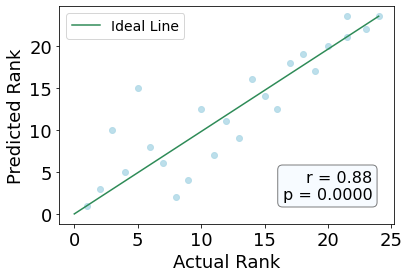

In [303]:
#Prediction comparison - Predicted rank vs True Rank
#1 year comparison
year = 2022

one_year = best_predictions_df[best_predictions_df['year'] == year] 
one_year = one_year.drop(['year'], axis=1)

# Merge the results dataframe with the original dataframe to get additional information
merged_df = pd.merge(df, one_year, left_index=True, right_on='Original_Index', how='inner')

# Calculate the actual ranks (total sum of points received)
actual_points = merged_df.groupby(['to_country','year'])['True_Label'].sum().sort_values(ascending=False)
actual_rank = actual_points.rank(ascending=False)

# Calculate the predicted ranks
predicted_points = merged_df.groupby(['to_country','year'])['Predicted_Label'].sum().sort_values(ascending=False)
predicted_rank = predicted_points.rank(ascending=False)


# Identify the highest rank
highest_rank = max(actual_rank.max(), predicted_rank.max())

# Filter out data points with the highest rank
filtered_actual_rank = actual_rank[actual_rank < highest_rank]
filtered_predicted_rank = predicted_rank[predicted_rank < highest_rank]

df_actual_rank = filtered_actual_rank.to_frame(name="rank")
df_predicted_rank = filtered_predicted_rank.to_frame(name="rank")

df_actual_rank.reset_index(inplace=True)
df_predicted_rank.reset_index(inplace=True)

df_actual_rank =df_actual_rank.sort_values(by=['to_country'])
df_predicted_rank=df_predicted_rank.sort_values(by=['to_country'])

# Create a scatterplot
plt.scatter(df_actual_rank['rank'], df_predicted_rank['rank'], color='lightblue', alpha=0.8)

#Plot ideal line
plt.plot([0, max(df_actual_rank['rank'])], [0, max(df_predicted_rank['rank'])], '-', color='seagreen', label='Ideal Line')

# Calculate Pearson correlation coefficient and p-value
corr_coeff, p_value = pearsonr(df_actual_rank['rank'], df_predicted_rank['rank'])


# Add labels and title
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')

# Add a legend
plt.legend(fontsize=14)

# Add correlation coefficient and p-value to the plot
textstr = f'r = {corr_coeff:.2f}\np = {p_value:.4f}'
props = dict(boxstyle='round', facecolor='aliceblue', alpha=0.5)
plt.gcf().text(0.85, 0.20, textstr, fontsize=16, bbox=props, ha='right', va='bottom')

# Display the plot
plt.savefig(f'plots/predicting_years/{year}.png', bbox_inches='tight')
plt.show()



In [159]:
plt.rcParams.update({'font.size': 20}) 


In [33]:
pd.set_option('display.max_columns', None)